In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.utils as utils

In [2]:
class BruteOSFMetric(metrics.BaseMetric):
    """Assume I can't trust the slewtime or visittime colums"""
    def __init__(self, metricName='BruteOSFMetric',
            expTimeCol='expTime', mjdCol='expMJD', maxgap=10., fudge=0, **kwargs):
        self.expTimeCol = expTimeCol
        self.maxgap = maxgap/60./24. # convert from min to days
        self.mjdCol = mjdCol
        self.fudge = fudge
        super(BruteOSFMetric, self).__init__(col=[self.expTimeCol, mjdCol],
                                                        metricName=metricName, units='OpenShutter/TotalTime',
                                                        **kwargs)
                                                                                                        
    def run(self, dataSlice, slicePoint=None):
        times = np.sort(dataSlice[self.mjdCol])
        diff = np.diff(times)
        good = np.where(diff < self.maxgap)
        openTime = np.sum(diff[good])*24.*3600.
        result = np.sum(dataSlice[self.expTimeCol]+self.fudge) / float(openTime)
        return result


In [3]:
conns = []
colmap_dicts = []
conns.append(db.SimpleDatabase('opsim3_61_sqlite.db', defaultTable='Summary', groupBy='expMJD',
                               defaultdbTables={'Summary': ['Summary', 'obsHistID']}))
colmap_dicts.append({'slewtime': 'slewTime', 'exptime': 'expTime', 'visittime': 'expTime', 'mjd':'expMJD'})



conns.append(db.SimpleDatabase('opsimblitz1_1131_sqlite.db', defaultTable='Summary', groupBy='expMJD',
                               defaultdbTables={'Summary': ['Summary', 'obsHistID']}))
colmap_dicts.append({'slewtime': 'slewTime', 'exptime': 'visitExpTime', 'visittime': 'visitTime', 'mjd':'expMJD'})


conns.append(db.SimpleDatabase('enigma_1189_sqlite.db', defaultTable='Summary', groupBy='expMJD',
                               defaultdbTables={'Summary': ['Summary', 'obsHistID']}))
colmap_dicts.append({'slewtime': 'slewTime', 'exptime': 'visitExpTime', 'visittime': 'visitTime', 'mjd':'expMJD'})


conns.append(db.SimpleDatabase('minion_1016_sqlite.db', defaultTable='Summary', groupBy='expMJD',
                               defaultdbTables={'Summary': ['Summary', 'obsHistID']}))
colmap_dicts.append({'slewtime': 'slewTime', 'exptime': 'visitExpTime', 'visittime': 'visitTime', 'mjd':'expMJD'})



In [5]:
results = []
i=0
for conn,colmap_dict in zip(conns, colmap_dicts):
    bundleList = []
    sql = ''
    slicer = slicers.UniSlicer()
    if i == 0:
        fudge = -4.
    else:
        fudge = 0.
    i += 1
    metric = BruteOSFMetric(expTimeCol=colmap_dict['exptime'],
                                   mjdCol=colmap_dict['mjd'], fudge=fudge)
    bundle = metricBundles.MetricBundle(metric, slicer, sql)
    bundleList.append(bundle)
    metric = metrics.MedianMetric(col='normairmass')
    bundle = metricBundles.MetricBundle(metric, slicer, sql)
    bundleList.append(bundle)
    
    metric = metrics.MedianMetric(col=colmap_dict['slewtime'])
    bundle = metricBundles.MetricBundle(metric, slicer, sql)
    bundleList.append(bundle)
    
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    group = metricBundles.MetricBundleGroup(bd, conn)
    group.runAll()
    results.append(bundleList)

Querying database Summary with no constraint for columns ['slewTime', 'airmass', 'fieldDec', 'expTime', 'expMJD'].
Found 2651588 visits
Running:  ['opsim_BruteOSFMetric_UNIS', 'opsim_Median_slewTime_UNIS', 'opsim_Median_normairmass_UNIS']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summary with no constraint for columns ['slewTime', 'airmass', 'fieldDec', 'visitExpTime', 'expMJD'].
Found 271849 visits
Running:  ['opsim_BruteOSFMetric_UNIS', 'opsim_Median_slewTime_UNIS', 'opsim_Median_normairmass_UNIS']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summary with no constraint for columns ['slewTime', 'airmass', 'fieldDec', 'visitExpTime', 'expMJD'].
Found 2469307 visits
Running:  ['opsim_BruteOSFMetric_UNIS', 'opsim_Median_slewTime_UNIS', 'opsim_Median_normairmass_UNIS']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed

In [6]:
osf = [bl[0].metricValues for bl in results]
normAir = [bl[1].metricValues for bl in results]

In [7]:
normAir

[masked_array(data = [1.0958415071696619],
              mask = [False],
        fill_value = -666.0), masked_array(data = [1.1717994414849806],
              mask = [False],
        fill_value = -666.0), masked_array(data = [1.0775495831422173],
              mask = [False],
        fill_value = -666.0), masked_array(data = [1.073198000531009],
              mask = [False],
        fill_value = -666.0)]

In [8]:
osf

[masked_array(data = [0.7431762502397868],
              mask = [False],
        fill_value = -666.0), masked_array(data = [0.7433393044559229],
              mask = [False],
        fill_value = -666.0), masked_array(data = [0.7333276606428204],
              mask = [False],
        fill_value = -666.0), masked_array(data = [0.735662801166647],
              mask = [False],
        fill_value = -666.0)]

In [9]:
print 30./(34)

0.882352941176


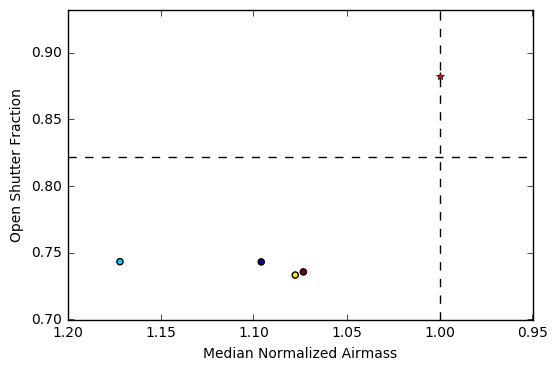

In [20]:
max_osf = 30./(34)
plt.scatter(normAir, osf, c=np.arange(len(normAir)))
plt.xlim([1.2, .95])
plt.ylim([.7, max_osf+.05])
plt.plot(1, max_osf, 'r*')
plt.xlabel('Median Normalized Airmass')
plt.ylabel('Open Shutter Fraction')
plt.axhline(y=30./(32.+4.5), linestyle='--', color='k')
plt.axvline(x=1., linestyle='--', color='k')